[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.instancenorm.InstanceNorm2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
Loading pretrained model LPIPS from /home/earthyzinc/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth
Loading pretrained model NIMA from /home/earthyzinc/.cache/torch/hub/checkpoints/NIMA_VGG16_ava-dc4e8265.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


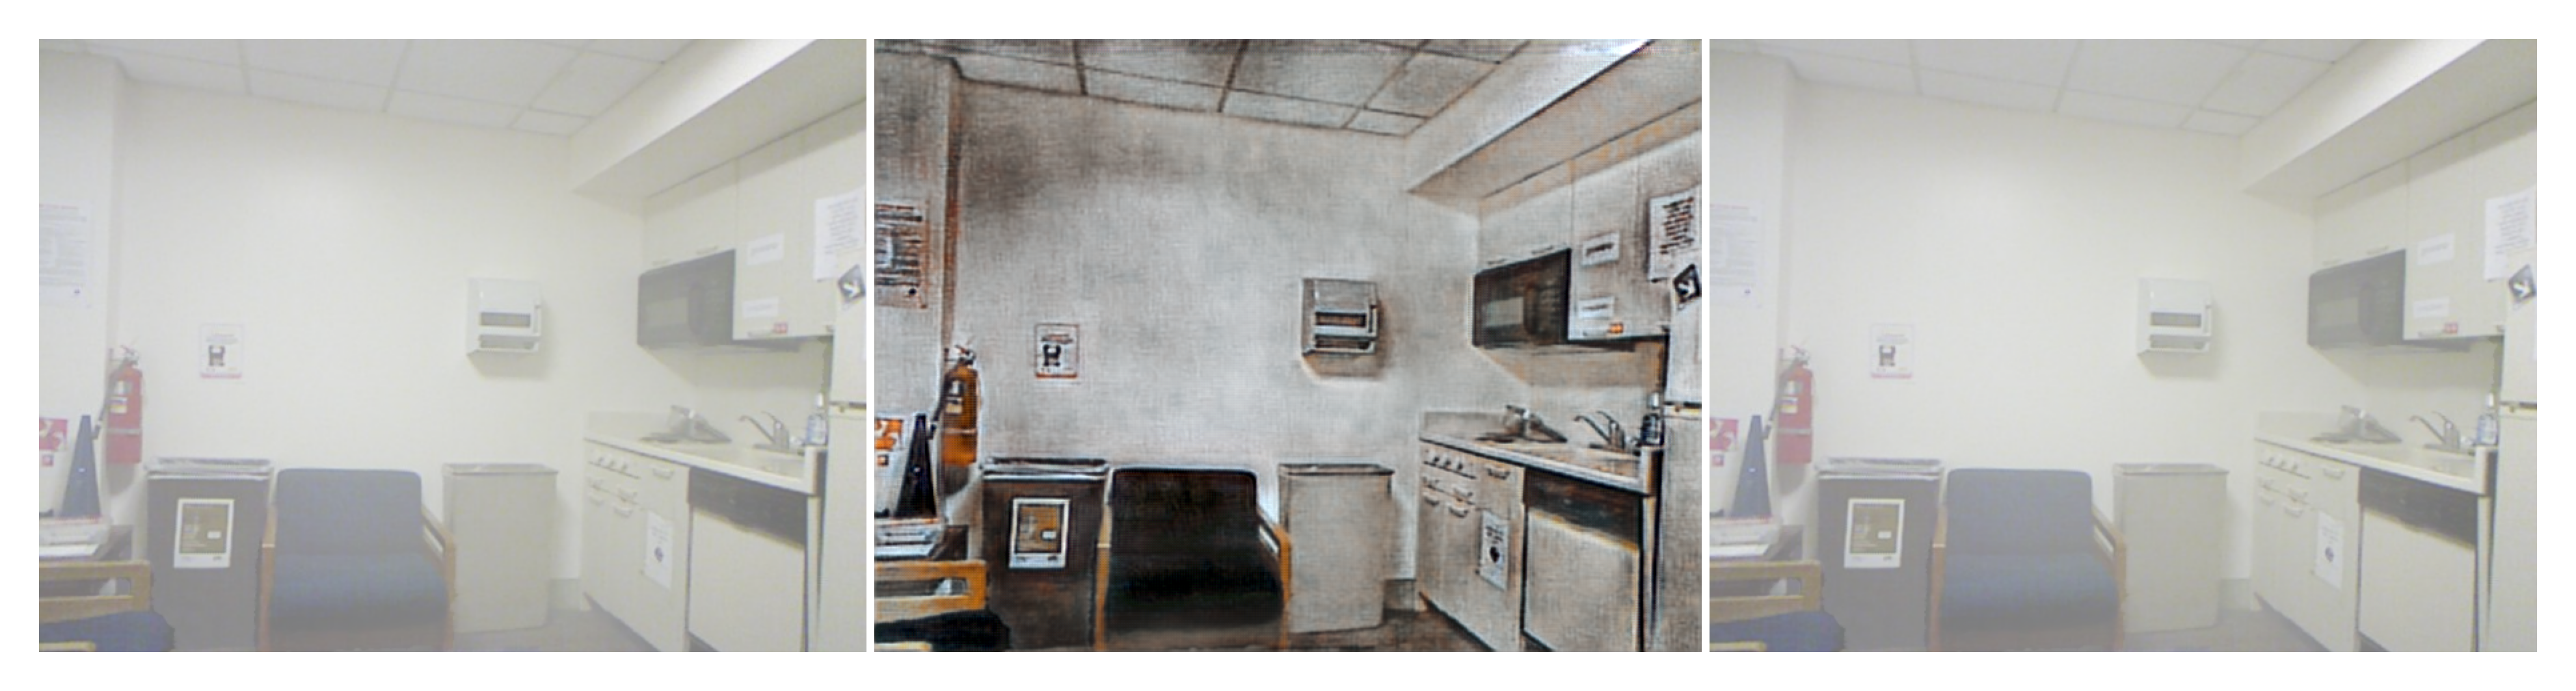

5208

In [7]:
import torch
import gc

from PIL import Image
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from basicsr.archs import build_network
from basicsr.models import build_model
from torch.utils.data import DataLoader
from collections import OrderedDict
import yaml
from os import path as osp
import os
from yaml import CLoader as Loader
from basicsr.data.ntire_dataset import NtireH5Dataset
options = "options/compare/GCA/DENSE-HAZE.yml"
root_path = osp.abspath(osp.join(os.getcwd(), osp.pardir))
options = os.path.join(root_path, options)
def dict_constructor(loader, node):
    return OrderedDict(loader.construct_pairs(node))
Loader.add_constructor(yaml.resolver.BaseResolver.DEFAULT_MAPPING_TAG, dict_constructor)

with open(options, mode='r') as f:
    opt = yaml.load(f, Loader=Loader)

opt['is_train'] = True
opt['dist'] = False
# opt['path']['pretrain_network_hq'] = os.path.join(root_path, opt['path']['pretrain_network_hq'])
experiments_root = osp.join(root_path, 'experiments', opt['name'])
model_path = osp.join(experiments_root, 'models')

# dataset_path = osp.join(root_path, opt['datasets']['test']['data_path'])
# dataloader = DataLoader(dataset=NtireH5Dataset(opt={"data_path": dataset_path, "shuffle": False}),
#                         num_workers=4, pin_memory=True, batch_size=1, shuffle=False)

model = build_model(opt)
test_net_g_opt = opt['network_g'].copy()
if test_net_g_opt.get('type') == 'FusionRefine':
    test_net_g_opt['opt']["use_weight"] = None
    test_net_g_opt['opt']["weight_alpha"] = -21.25
test_net_g = build_network(test_net_g_opt)
model.model_to_device(test_net_g)
best_net_g_path = osp.join(experiments_root, 'models/net_g_best_.pth')
if osp.isfile(best_net_g_path):
    model.load_network(test_net_g, best_net_g_path, False)
test_net_g = model.get_bare_model(test_net_g)
test_net_g.eval()


# for data in dataloader:
hazy = ToTensor()(Image.open("/mnt/d/DeepLearning/dataset/RESIDE/ITS/hazy/1_6_0.9039.png"))[None, ::].cuda()
clean = ToTensor()(Image.open("/mnt/d/DeepLearning/dataset/RESIDE/ITS/hazy/1_6_0.9039.png"))[None, ::].cuda()
# clean = data["gt"].cuda()
# hazy = data["lq"].cuda()
recover = test_net_g(hazy)
plt.rcParams['figure.dpi'] = 600
fig, axs = plt.subplots(1, 3)

axs.flat[0].imshow(hazy.cpu().detach().squeeze().permute(1, 2, 0).numpy())
axs.flat[0].axis('off')
axs.flat[1].imshow(recover.cpu().detach().squeeze().permute(1, 2, 0).numpy())
axs.flat[1].axis('off')
axs.flat[2].imshow(clean.cpu().detach().squeeze().permute(1, 2, 0).numpy())
axs.flat[2].axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.01, hspace=0)
plt.savefig('your_image.png', bbox_inches='tight', pad_inches=0)
plt.show()


del model
torch.cuda.empty_cache()
gc.collect()